# 1.1 Start

---



In [72]:
# importing some libraries (not all are currently used)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

import random

# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


# 2.1 Data Analysis

In [73]:
x_data = np.load('x_BALANCED_V2.npy')
y_data = np.load('y_BALANCED_V2.npy')

In [74]:
y_data

array([2, 4, 1, ..., 4, 4, 4])

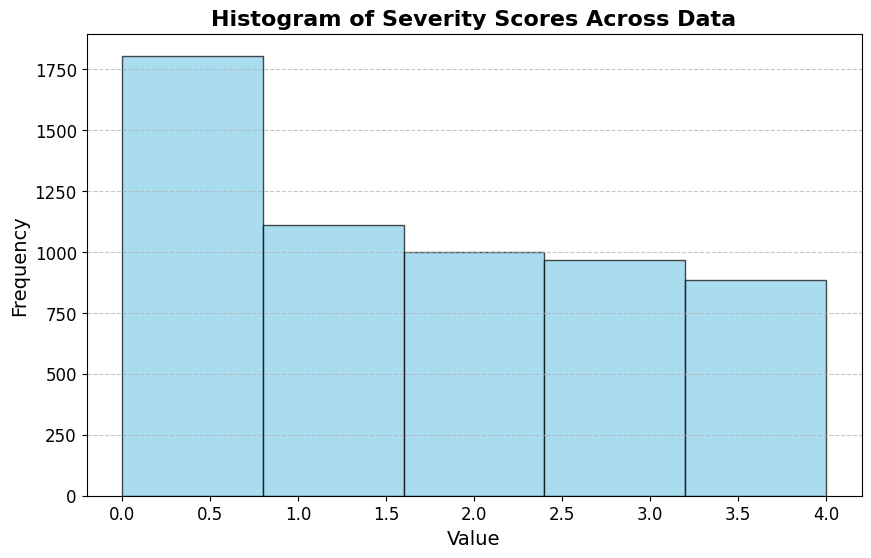

In [75]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_data, bins=5, edgecolor='black', color='skyblue', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Severity Scores Across Data', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [76]:
import numpy as np

def count_occurrences_bincount(arr):
    # Ensure input is a NumPy array of non-negative integers
    if not np.issubdtype(arr.dtype, np.integer) or np.any(arr < 0):
        raise ValueError("Input array must be a NumPy array of non-negative integers.")

    counts = np.bincount(arr)
    return counts

# Example usage
arr = y_data
counts = count_occurrences_bincount(arr)
print(counts)

[1805 1110  999  965  885]


([<matplotlib.patches.Wedge at 0x7a501206dff0>,
 [Text(0.6092566218548332, 0.9158637282511176, 'No DR'),
  Text(-0.9266732192382663, 0.5926860423078886, 'Mild'),
  Text(-0.9198289439425081, -0.6032534408402578, 'Moderate'),
  Text(0.08803817384475326, -1.096471285509147, 'Severe'),
  Text(0.974494116397915, -0.5102560309353014, 'PR DR')])

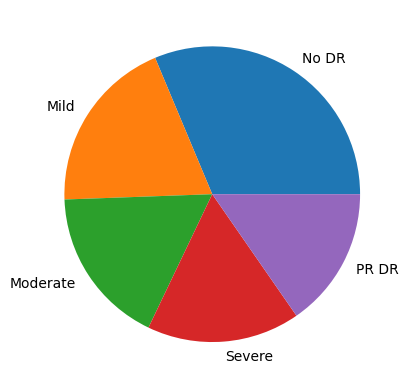

In [77]:
import matplotlib.pyplot as plt

labels = 'No DR', 'Mild', 'Moderate', 'Severe', 'PR DR'
sizes = counts

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

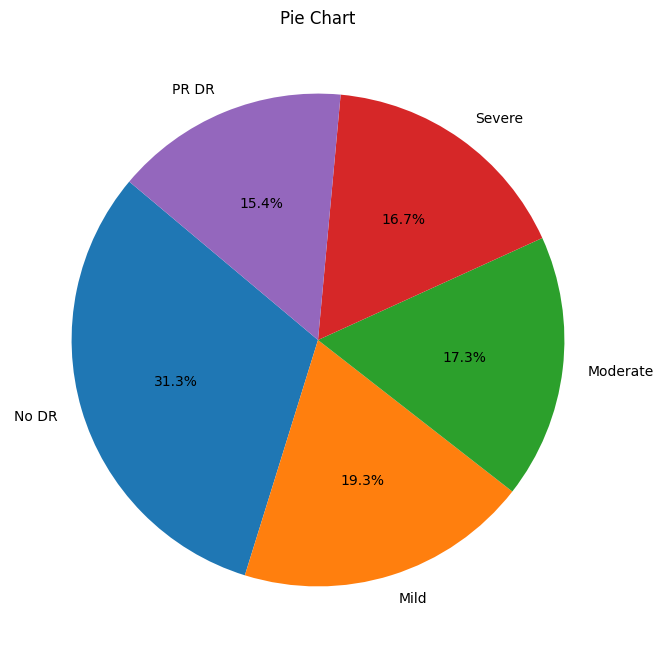

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Example numpy array with data for the pie chart
data = counts
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'PR DR']


# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: Adjust the figure size
plt.pie(data, labels=[f'{labels[i]}' for i in range(len(data))], autopct='%1.1f%%', startangle=140)

# Title for the pie chart
plt.title('Pie Chart')

# Show the plot
plt.show()

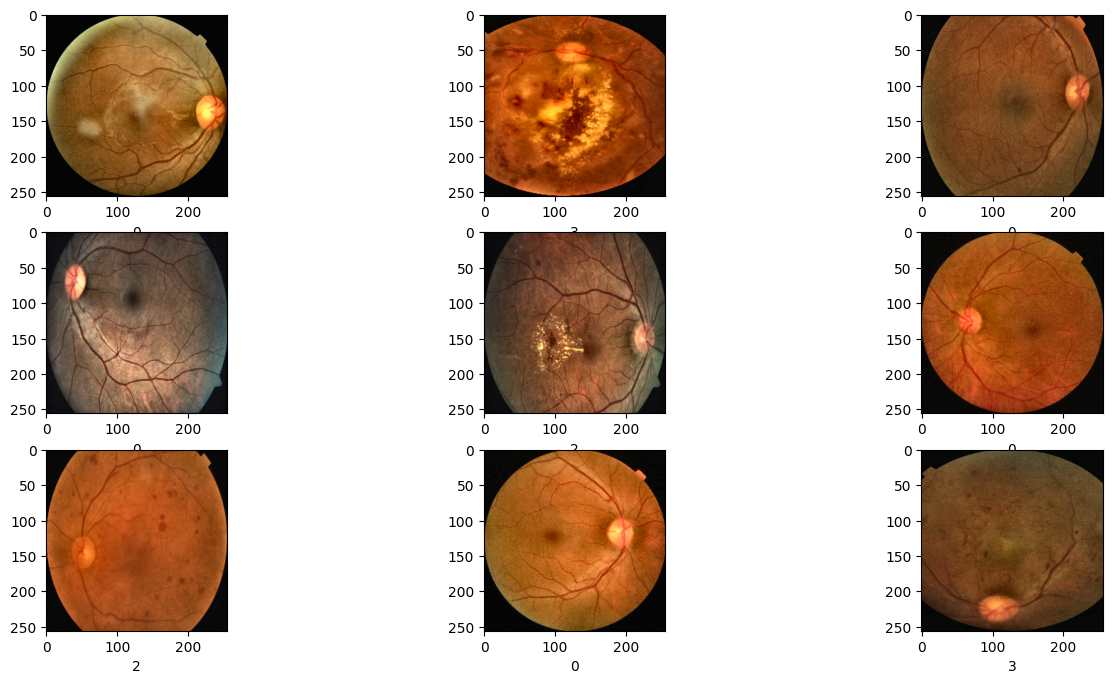

In [79]:
from numpy import random

plt.figure(figsize=(16,8))

arr = random.randint(len(x_data), size=(9))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[arr[i]])
  plt.imshow(x_data[arr[i]])



# 3.1 Data Upload

---



In [80]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [81]:
import torch
from torchvision import transforms
from PIL import Image, ImageFilter
import random

class PreprocessedRetinaDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):

        image = self.x_train[idx]
        label = self.y_train[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


"""transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,)),
])"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.RandomHorizontalFlip(),  # Add random horizontal flipping
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Add Gaussian blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.batch_norm4 = nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 128)
        self.dropout = nn.Dropout(p=0.05)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))

        x = x.view(-1, 128 * 14 * 14)  # Flatten with the correct size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

model = EnhancedCNN()

In [83]:
# Create datasets and dataloaders
trainset = PreprocessedRetinaDataset(x_train=x_train, y_train=y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

validset = PreprocessedRetinaDataset(x_train=x_val, y_train=y_val, transform=transform)
validloader = DataLoader(validset, batch_size=64, shuffle=False)


# 5.1 Training

---



In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, num_classes=5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # Compute the base cross-entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Compute class probabilities from logits
        probs = F.softmax(inputs, dim=1)

        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute the probability assigned to the true class
        pt = torch.sum(probs * targets_one_hot, dim=1)

        # Compute alpha_t
        alpha_t = self.alpha * targets_one_hot + (1 - self.alpha) * (1 - targets_one_hot)

        # Compute the focal loss
        focal_loss = alpha_t * (1 - pt.unsqueeze(1)) ** self.gamma * ce_loss

        # Reduce the loss as specified (mean reduction by default)
        return focal_loss.mean()

In [85]:
#criterion = FocalLoss(alpha = 0.25, gamma=2.0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


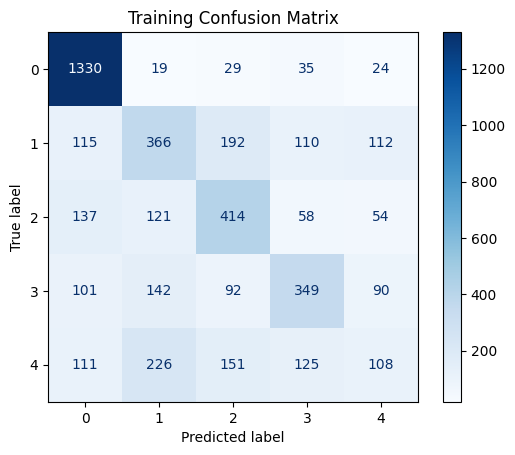

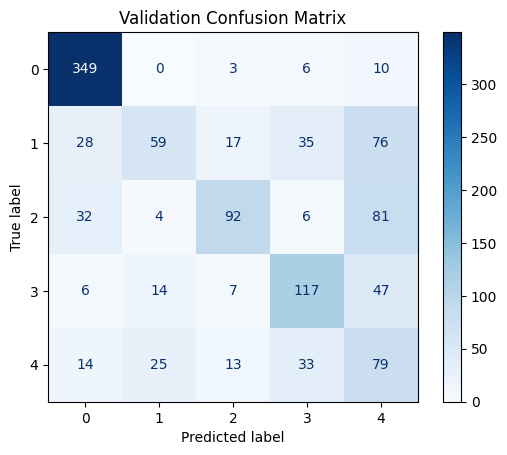

--- 520.1604974269867 seconds ---
Epoch 1: Train Loss: 1.088, Train Accuracy: 55.671%, Valid Loss: 0.931, Valid Accuracy: 60.364%
Train AUROC: 0.815, Train F1: 0.533%, Valid AUROC: 0.873, Valid F1: 0.597%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


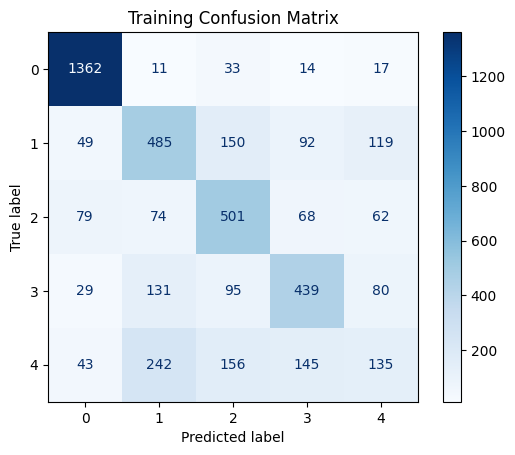

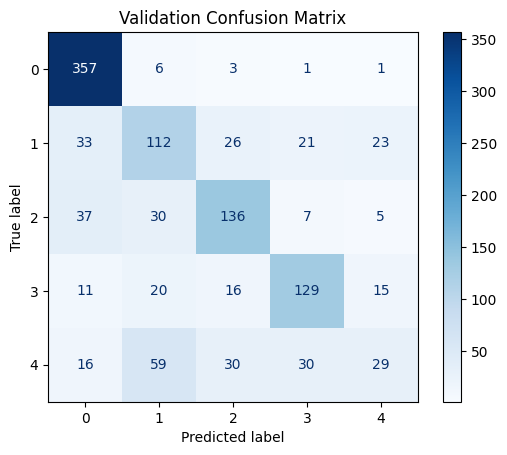

--- 475.0902111530304 seconds ---
Epoch 2: Train Loss: 0.919, Train Accuracy: 63.37%, Valid Loss: 0.89, Valid Accuracy: 66.175%
Train AUROC: 0.863, Train F1: 0.618%, Valid AUROC: 0.882, Valid F1: 0.638%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


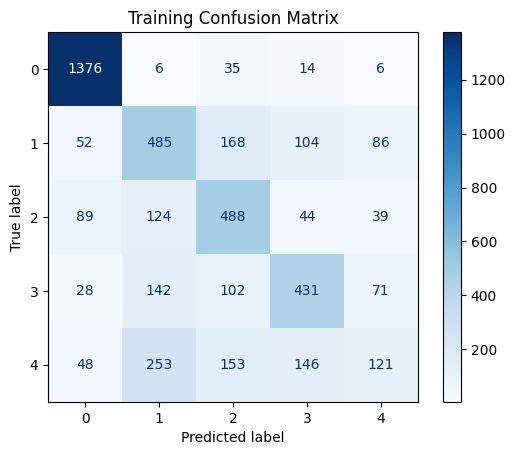

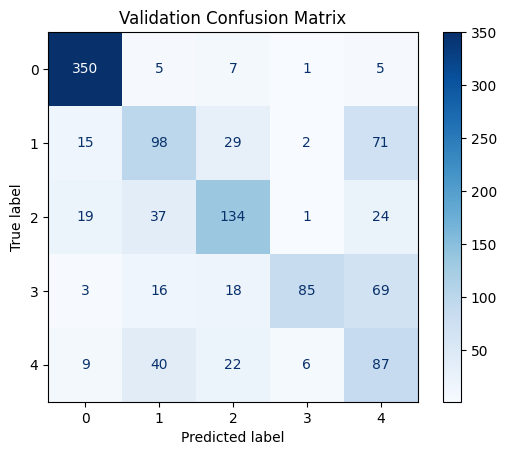

--- 490.0732114315033 seconds ---
Epoch 3: Train Loss: 0.887, Train Accuracy: 62.915%, Valid Loss: 0.846, Valid Accuracy: 65.395%
Train AUROC: 0.869, Train F1: 0.61%, Valid AUROC: 0.89, Valid F1: 0.656%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


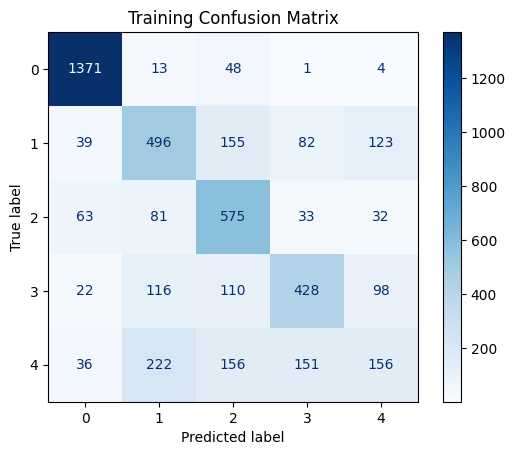

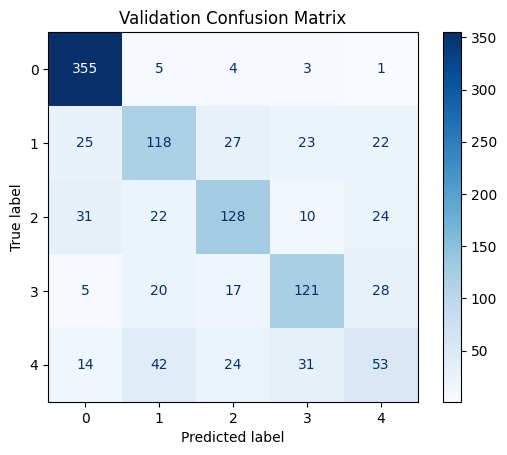

--- 466.6877419948578 seconds ---
Epoch 4: Train Loss: 0.835, Train Accuracy: 65.626%, Valid Loss: 0.807, Valid Accuracy: 67.216%
Train AUROC: 0.883, Train F1: 0.641%, Valid AUROC: 0.893, Valid F1: 0.661%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


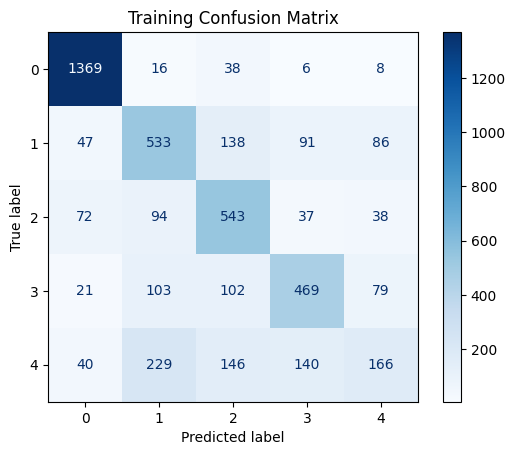

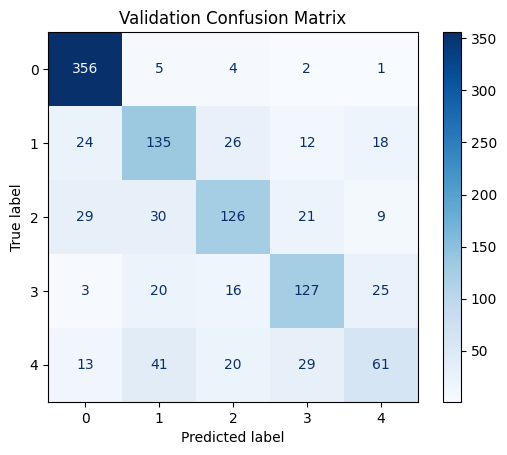

--- 453.08566188812256 seconds ---
Epoch 5: Train Loss: 0.823, Train Accuracy: 66.797%, Valid Loss: 0.798, Valid Accuracy: 69.818%
Train AUROC: 0.888, Train F1: 0.653%, Valid AUROC: 0.901, Valid F1: 0.687%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


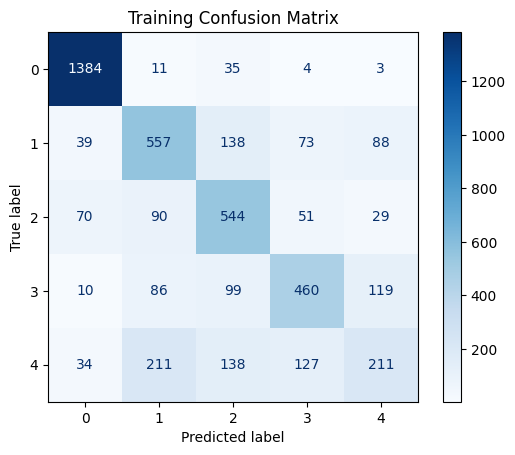

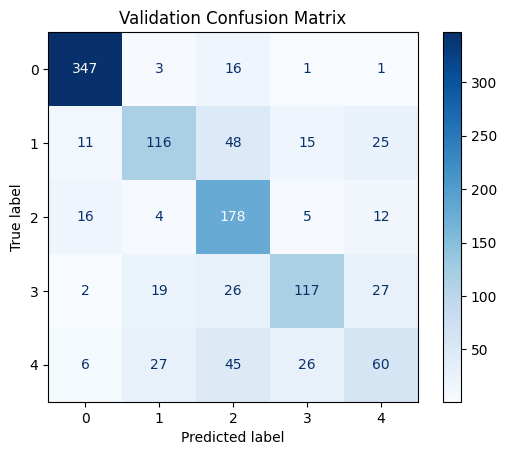

--- 468.33041429519653 seconds ---
Epoch 6: Train Loss: 0.769, Train Accuracy: 68.445%, Valid Loss: 0.711, Valid Accuracy: 70.945%
Train AUROC: 0.899, Train F1: 0.673%, Valid AUROC: 0.911, Valid F1: 0.702%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


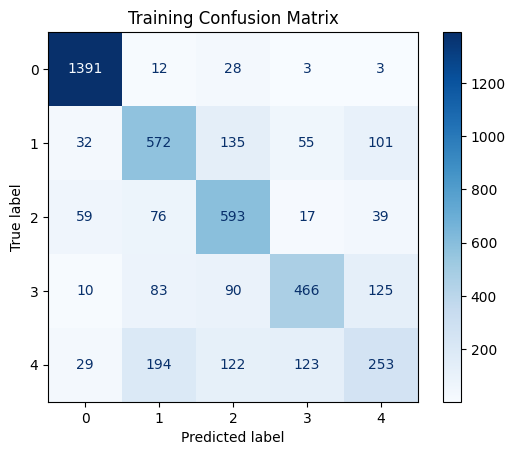

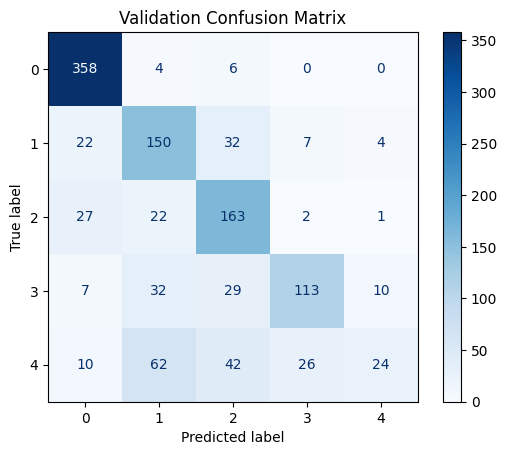

--- 462.51533246040344 seconds ---
Epoch 7: Train Loss: 0.714, Train Accuracy: 71.026%, Valid Loss: 0.738, Valid Accuracy: 70.078%
Train AUROC: 0.912, Train F1: 0.702%, Valid AUROC: 0.91, Valid F1: 0.673%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


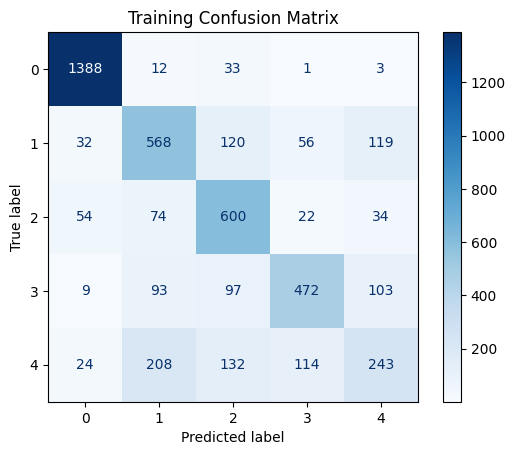

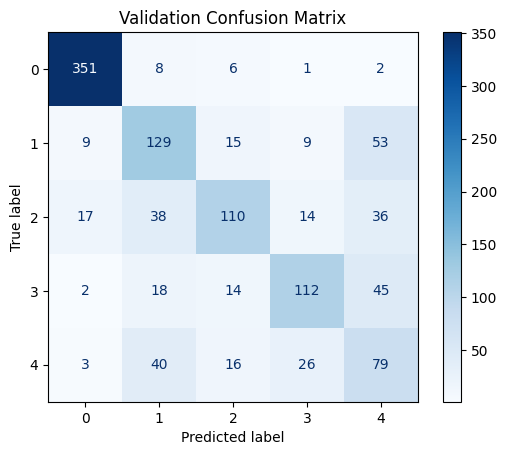

--- 462.7849178314209 seconds ---
Epoch 8: Train Loss: 0.725, Train Accuracy: 70.939%, Valid Loss: 0.766, Valid Accuracy: 67.736%
Train AUROC: 0.911, Train F1: 0.701%, Valid AUROC: 0.907, Valid F1: 0.68%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


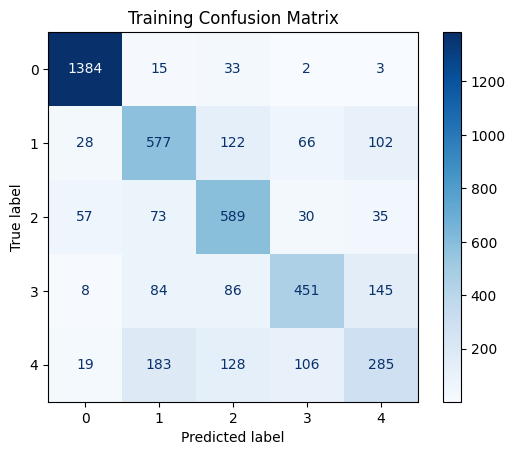

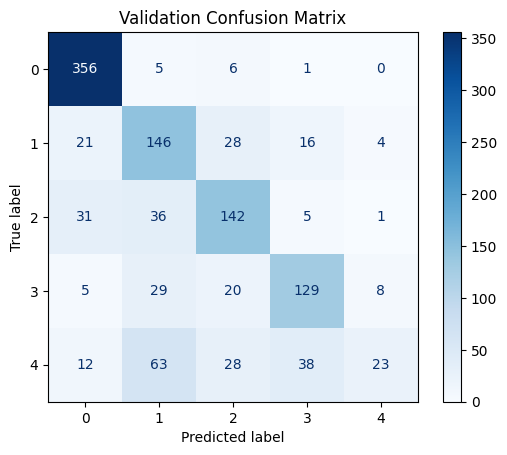

--- 451.23106026649475 seconds ---
Epoch 9: Train Loss: 0.709, Train Accuracy: 71.264%, Valid Loss: 0.77, Valid Accuracy: 69.037%
Train AUROC: 0.916, Train F1: 0.707%, Valid AUROC: 0.909, Valid F1: 0.663%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


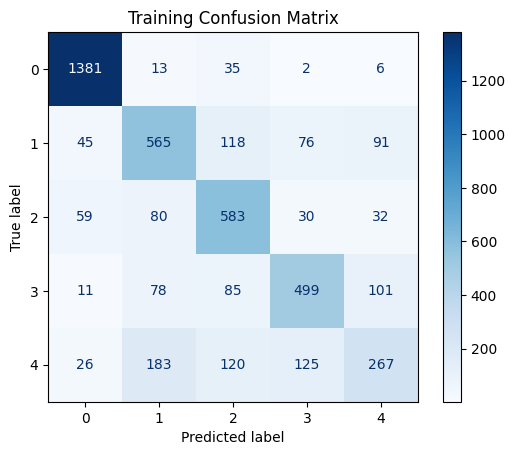

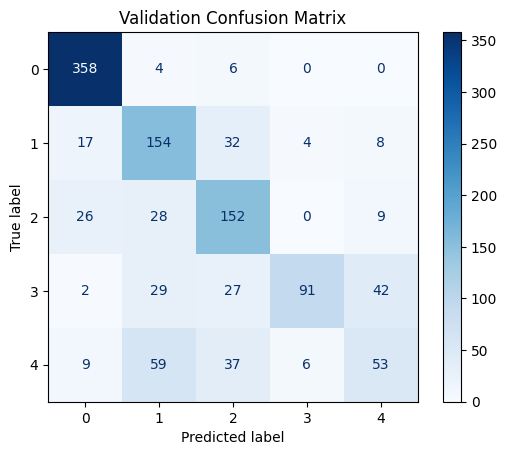

--- 459.2828280925751 seconds ---
Epoch 10: Train Loss: 0.705, Train Accuracy: 71.46%, Valid Loss: 0.748, Valid Accuracy: 70.078%
Train AUROC: 0.917, Train F1: 0.707%, Valid AUROC: 0.909, Valid F1: 0.689%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


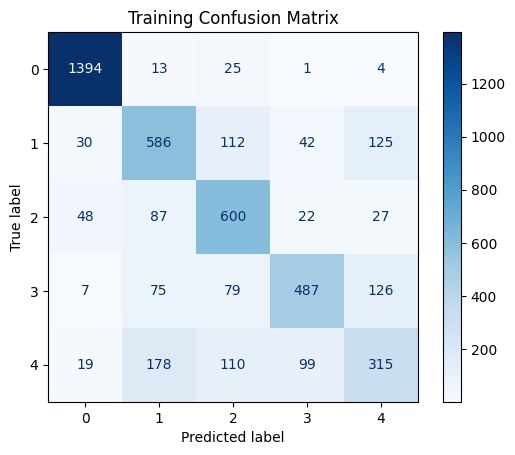

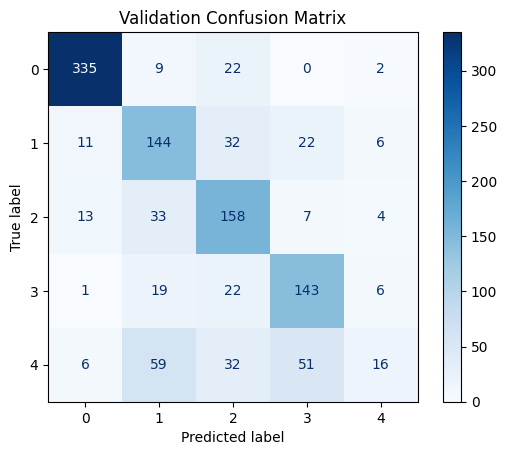

--- 467.9018576145172 seconds ---
Epoch 11: Train Loss: 0.65, Train Accuracy: 73.346%, Valid Loss: 0.74, Valid Accuracy: 69.037%
Train AUROC: 0.926, Train F1: 0.729%, Valid AUROC: 0.907, Valid F1: 0.663%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


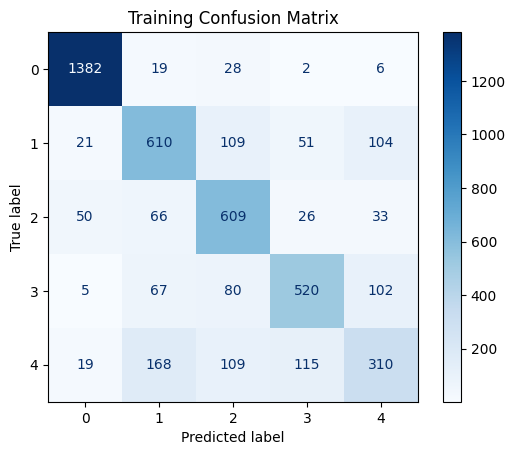

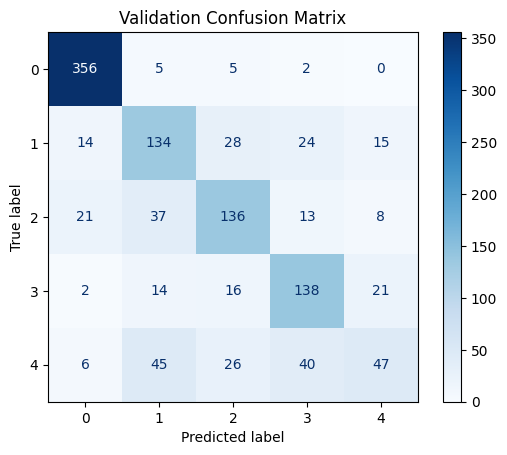

--- 464.0355534553528 seconds ---
Epoch 12: Train Loss: 0.648, Train Accuracy: 74.409%, Valid Loss: 0.705, Valid Accuracy: 70.338%
Train AUROC: 0.934, Train F1: 0.739%, Valid AUROC: 0.913, Valid F1: 0.691%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


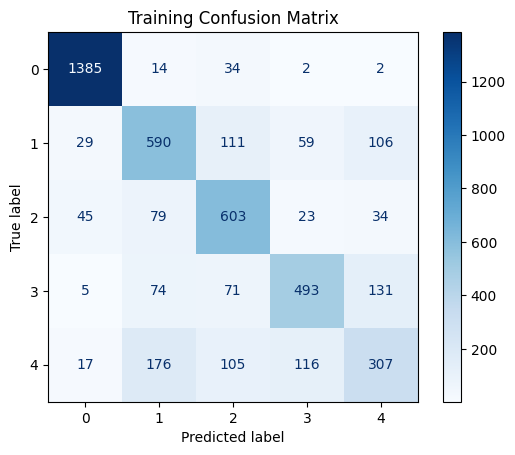

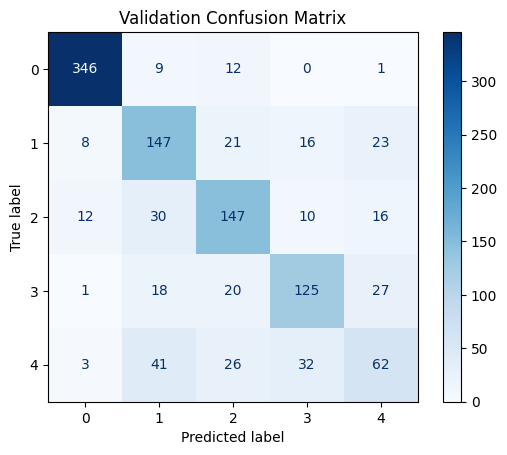

--- 464.58833503723145 seconds ---
Epoch 13: Train Loss: 0.638, Train Accuracy: 73.26%, Valid Loss: 0.716, Valid Accuracy: 71.726%
Train AUROC: 0.93, Train F1: 0.728%, Valid AUROC: 0.914, Valid F1: 0.714%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


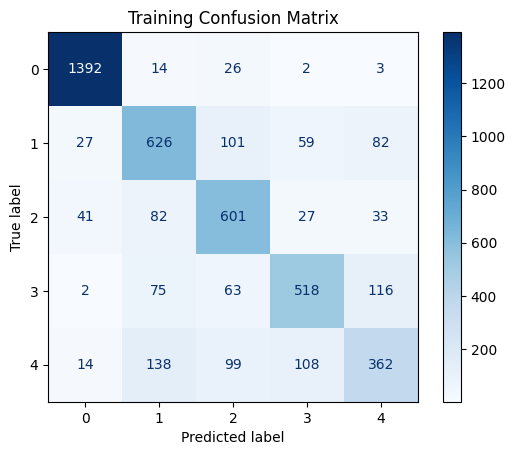

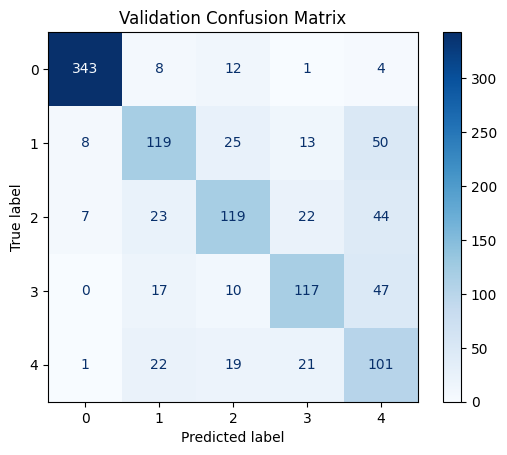

--- 462.8061521053314 seconds ---
Epoch 14: Train Loss: 0.6, Train Accuracy: 75.884%, Valid Loss: 0.748, Valid Accuracy: 69.297%
Train AUROC: 0.941, Train F1: 0.756%, Valid AUROC: 0.913, Valid F1: 0.698%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


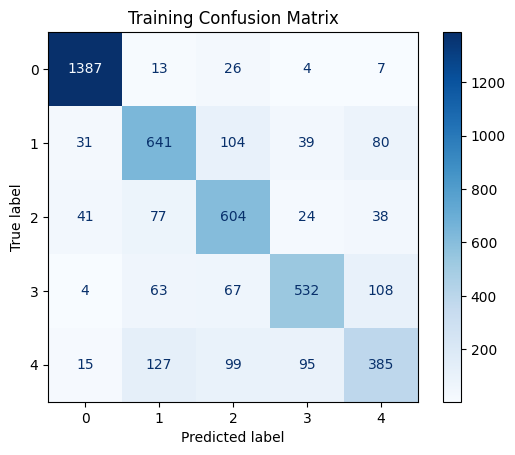

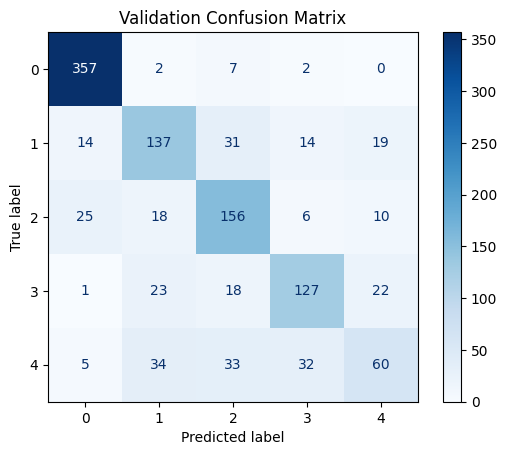

--- 463.9857518672943 seconds ---
Epoch 15: Train Loss: 0.58, Train Accuracy: 76.968%, Valid Loss: 0.671, Valid Accuracy: 72.593%
Train AUROC: 0.944, Train F1: 0.767%, Valid AUROC: 0.92, Valid F1: 0.717%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


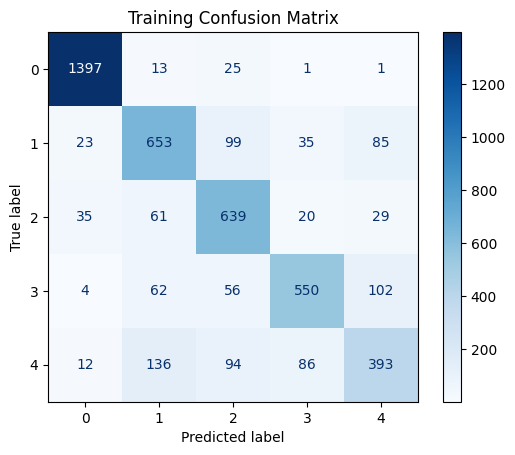

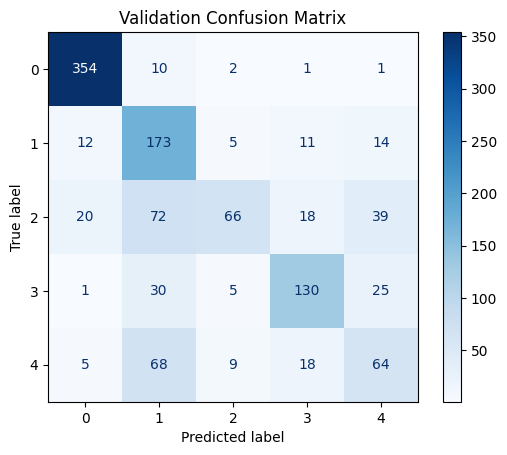

--- 461.50977993011475 seconds ---
Epoch 16: Train Loss: 0.544, Train Accuracy: 78.768%, Valid Loss: 0.868, Valid Accuracy: 68.257%
Train AUROC: 0.95, Train F1: 0.785%, Valid AUROC: 0.911, Valid F1: 0.668%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


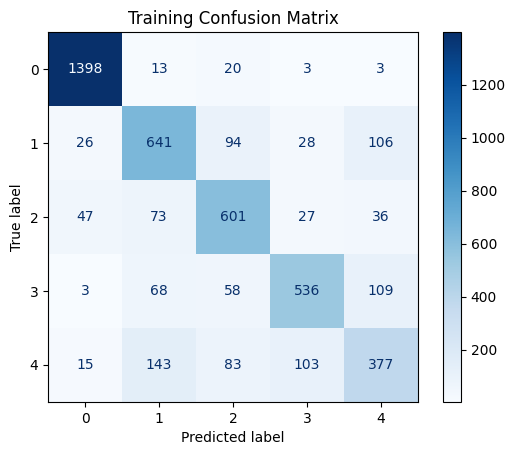

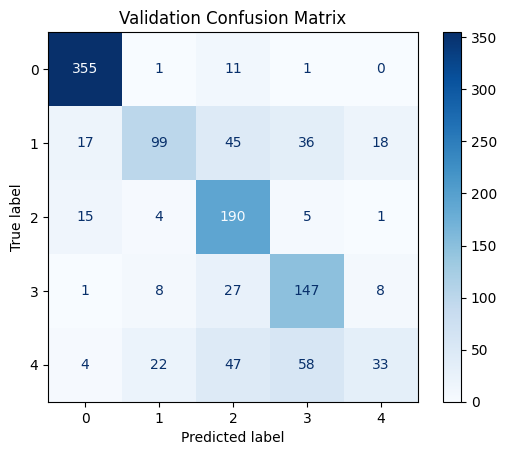

--- 453.7540726661682 seconds ---
Epoch 17: Train Loss: 0.558, Train Accuracy: 77.055%, Valid Loss: 0.747, Valid Accuracy: 71.466%
Train AUROC: 0.947, Train F1: 0.768%, Valid AUROC: 0.916, Valid F1: 0.69%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


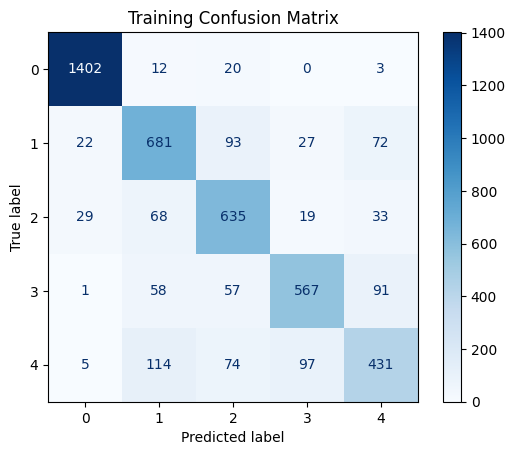

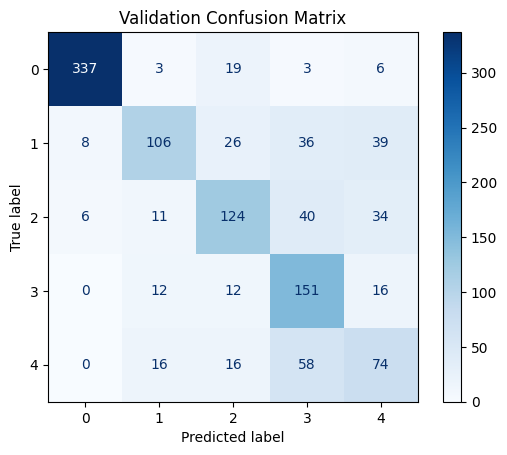

--- 456.252525806427 seconds ---
Epoch 18: Train Loss: 0.493, Train Accuracy: 80.59%, Valid Loss: 0.796, Valid Accuracy: 68.69%
Train AUROC: 0.961, Train F1: 0.804%, Valid AUROC: 0.907, Valid F1: 0.688%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


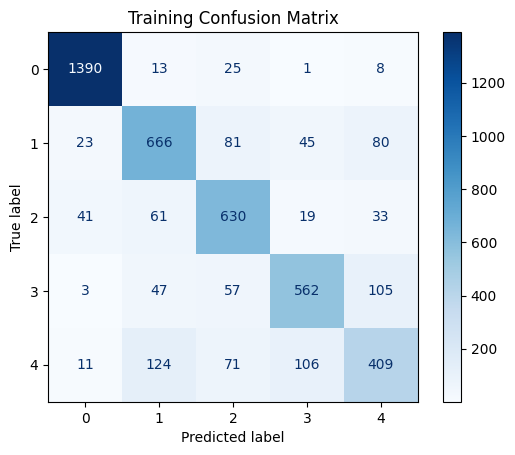

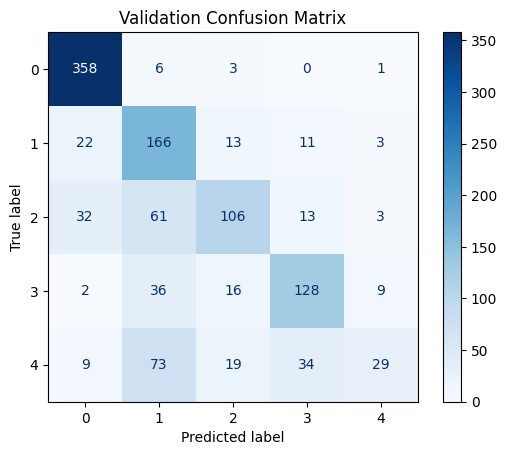

--- 451.84582924842834 seconds ---
Epoch 19: Train Loss: 0.51, Train Accuracy: 79.31%, Valid Loss: 0.844, Valid Accuracy: 68.257%
Train AUROC: 0.956, Train F1: 0.791%, Valid AUROC: 0.915, Valid F1: 0.658%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


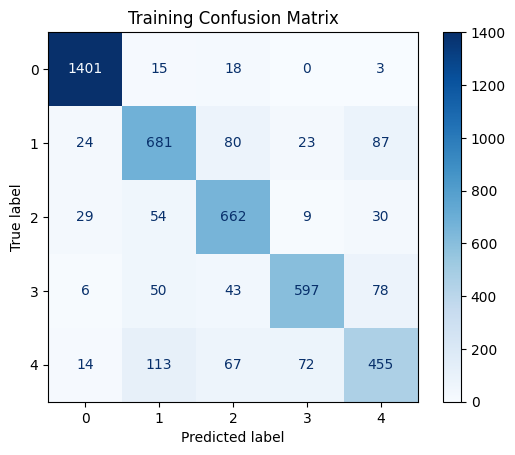

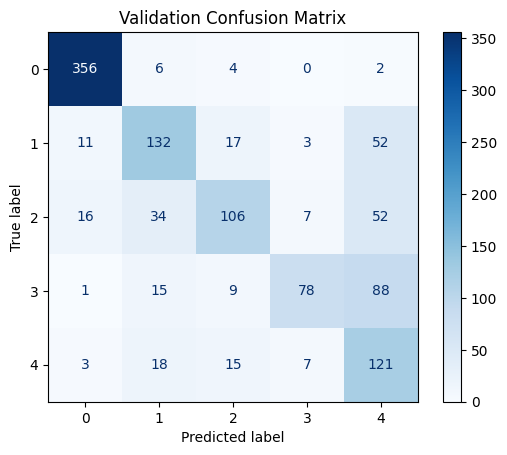

--- 449.80528020858765 seconds ---
Epoch 20: Train Loss: 0.47, Train Accuracy: 82.325%, Valid Loss: 0.777, Valid Accuracy: 68.777%
Train AUROC: 0.963, Train F1: 0.822%, Valid AUROC: 0.924, Valid F1: 0.688%


In [87]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import time


def train(model, train_loader, valid_loader, criterion, optimizer, epochs=1):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_f1s, valid_f1s = [], []
    train_auc_scores, train_aurocs = [], []
    valid_auc_scores, valid_aurocs = [], []
    train_tp, train_tn, train_fp, train_fn = [], [], [], []
    valid_tp, valid_tn, valid_fp, valid_fn = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        all_train_labels, all_train_preds = [], []
        start_time = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)

        # Calculate confusion matrix and TP, TN, FP, FN
        cm = confusion_matrix(all_train_labels, np.argmax(all_train_preds, axis=1), labels=list(range(6)))
        tp, fn, fp, tn = calculate_tp_fn_fp_tn(cm)
        train_tp.append(tp)
        train_tn.append(tn)
        train_fp.append(fp)
        train_fn.append(fn)

        # Calculate AUROC and F1 score
        all_train_labels = np.array(all_train_labels)
        all_train_preds = np.array(all_train_preds)
        train_auroc = roc_auc_score(all_train_labels, all_train_preds, multi_class='ovr') if len(np.unique(all_train_labels)) > 1 else float('nan')
        train_f1 = f1_score(all_train_labels, np.argmax(all_train_preds, axis=1), average='weighted')

        # Add to lists
        train_aurocs.append(train_auroc)
        train_f1s.append(train_f1)

        # VALIDATION STEPS
        valid_loss, valid_accuracy, valid_auroc, valid_f1, valid_labels, valid_preds = validate(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_aurocs.append(valid_auroc)
        valid_f1s.append(valid_f1)

        # Plot confusion matrices
        plot_confusion_matrix(np.array(all_train_labels), np.argmax(np.array(all_train_preds), axis=1), title='Training Confusion Matrix')
        plot_confusion_matrix(np.array(valid_labels), np.argmax(np.array(valid_preds), axis=1), title='Validation Confusion Matrix')

        curr = time.ctime(time.time())
        print("--- %s seconds ---" % (time.time() - start_time))
        print(f"Epoch {epoch+1}: Train Loss: {round(train_loss, 3)}, Train Accuracy: {round(train_accuracy, 3)}%, Valid Loss: {round(valid_loss, 3)}, Valid Accuracy: {round(valid_accuracy, 3)}%")
        print(f"Train AUROC: {round(train_auroc, 3)}, Train F1: {round(train_f1, 3)}%, Valid AUROC: {round(valid_auroc, 3)}, Valid F1: {round(valid_f1, 3)}%")

    return (train_losses, valid_losses, train_accuracies, valid_accuracies,
            train_aurocs, valid_aurocs,
            train_tp, train_tn, train_fp, train_fn,
            valid_tp, valid_tn, valid_fp, valid_fn)

def validate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_valid_labels, all_valid_preds = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect data for AUROC and F1 score
            all_valid_labels.extend(labels.cpu().numpy())
            all_valid_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    # Calculate AUROC and F1 score
    all_valid_labels = np.array(all_valid_labels)
    all_valid_preds = np.array(all_valid_preds)
    valid_f1 = f1_score(all_valid_labels, np.argmax(all_valid_preds, axis=1), average='weighted')
    valid_auroc = roc_auc_score(all_valid_labels, all_valid_preds, multi_class='ovr') if len(np.unique(all_valid_labels)) > 1 else float('nan')

    # Calculate confusion matrix and TP, TN, FP, FN
    cm = confusion_matrix(all_valid_labels, np.argmax(all_valid_preds, axis=1), labels=list(range(6)))
    valid_tp, valid_fn, valid_fp, valid_tn = calculate_tp_fn_fp_tn(cm)

    return valid_loss, valid_accuracy, valid_auroc, valid_f1, all_valid_labels, all_valid_preds

def calculate_tp_fn_fp_tn(cm):
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    return tp, fn, fp, tn

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(5)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(5)))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies, train_aurocs, valid_aurocs, train_tp, train_tn, train_fp, train_fn, valid_tp, valid_tn, valid_fp, valid_fn = train(model, trainloader, validloader, criterion, optimizer, epochs=20)


In [ ]:
torch.save(model, 'Model_CNN_FocalLoss20EPOCHS.pt')

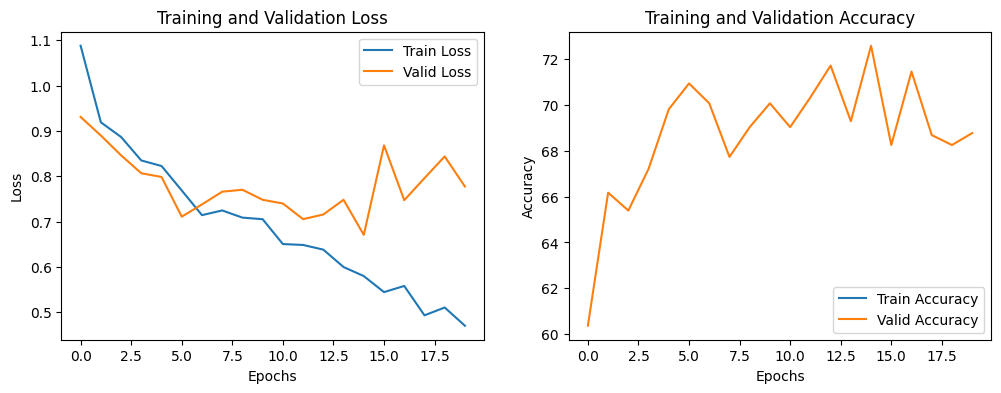

In [89]:
6# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()